In [20]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.sparse as spar
import scipy.special as spec
import sys
from matplotlib import pyplot as plt

In [2]:
V = 1000 # nr words in vocabulary
M = 10 # nr documents
K = 5 # nr of topics
alpha = .1 # dirichlet hyperparameter

X = np.random.binomial(1,.3, size=M*V).reshape(M,V)
X = spar.csr_matrix(X, dtype=float)

In [3]:
# For even a reasonable setup like 10K vocabulary, 5K documents and 20 topics, the size of the tensor indexed by
# <document, word, topic> simply explodes to 7.5G. This is why we can't explicitly keep all of $\phi$ in the memory.
# Instead, we iterate over the documents one by one, and accumulate the phi parameter

In [42]:
# model parameters
beta = np.random.rand(K, V)

for epoch in range(10):
    # E-step
    
    gamma = np.zeros((K, M)) + alpha + (nr_terms/float(K)) # mth document, i th topic
    beta_acc = np.zeros((K, V))
    
#     print "new epoch"
    
    for m in range(9): # iterate over all documents
#         print "new doc"
        phi = np.zeros((K, V), dtype=float) + 1./K

        ixw = (X[m, :] > 0).toarray().squeeze() # an index to words which have appeared in the document
        gammad = gamma[:, m] # slice for the document only once
        
        for ctr in range(int(1000)): 
            # store the previous values
            # TODO: make this more efficient
            phi_prev = phi.copy()
            gammad_prev = gammad.copy()
            
#             print (np.linalg.norm(phi_prev), np.linalg.norm(gammad_prev))

            # update phi
            # WARN: exp digamma underflows < 1e-3! 
            # TODO: digamma update is wrong! -spec.digamma(np.sum(gammad))
            phi[:, ixw] = ((beta[:, ixw]).T * np.exp(spec.digamma(gammad))).T 
            phi = phi / np.sum(phi, 0) # normalize phi columns
            
            # update gamma
            gammad = alpha + np.sum(phi, axis=1)

            # check for convergence
            dphinorm = np.linalg.norm(phi - phi_prev, "fro") #/ float(K * V)
            dgammadnorm = np.linalg.norm(gammad - gammad_prev)
            
            if dphinorm < .01 and dgammadnorm < .01:
#                 print (dphinorm, dgammadnorm, np.linalg.norm(phi, "fro"), np.linalg.norm(gammad))
                break
#             else:
#                 print (dphinorm, dgammadnorm, np.linalg.norm(phi, "fro"), np.linalg.norm(gammad))

        gamma[:, m] = gammad
        beta_acc[:, ixw] += phi[:, ixw]

    # M-step
    # TODO: check for numerical stability
    beta = (beta_acc.T / np.sum(beta_acc, axis=1)).T # normalize beta rows

new epoch
new doc
new doc
new doc
new doc
new doc
new doc
new doc
new doc
new doc
new epoch
new doc
new doc
new doc
new doc
new doc
new doc
new doc
new doc
new doc
new epoch
new doc
new doc
new doc
new doc
new doc
new doc
new doc
new doc
new doc
new epoch
new doc
new doc
new doc
new doc
new doc
new doc
new doc
new doc
new doc
new epoch
new doc
new doc
new doc
new doc
new doc
new doc
new doc
new doc
new doc


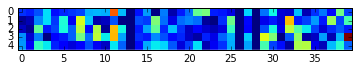

In [43]:
plt.imshow(beta[:,:40],interpolation="none")

In [26]:
np.sum(beta,1)

array([ 1.,  1.,  1.,  1.,  1.])

In [37]:
np.exp(spec.digamma(gammad))

array([ 199.60020875,  199.60020875,  199.60020875,  199.60020875,
        199.60020875])

In [ ]:
range(2)